# Assignment 2 - Bank Marketing

Link to the data: https://archive.ics.uci.edu/dataset/222/bank+marketing

The data is related with direct marketing campaigns of a Portuguese banking institution. The marketing campaigns were based on phone calls. Often, more than one contact to the same client was required, in order to access if the product (bank term deposit) would be ('yes') or not ('no') subscribed. 

There are four datasets: 
1) bank.csv with 10% of the examples and 17 inputs, randomly selected from 3 (older version of this dataset with less inputs). 
2) bank-full.csv with all examples and 17 inputs, ordered by date (older version of this dataset with less inputs). 
3) bank-additional.csv with 10% of the examples (4119), randomly selected from 1), and 20 inputs.
4) bank-additional-full.csv with all examples (41188) and 20 inputs, ordered by date (from May 2008 to November 2010), very close to the data analyzed in [Moro et al., 2014]
The smallest datasets are provided to test more computationally demanding machine learning algorithms (e.g., SVM). 

The classification goal is to predict if the client will subscribe (yes/no) a term deposit (variable y) by this research question:

'Which features of client demographics, marketing strategies, and external economic indicators most strongly influence the likelihood of subscribing to a bank term deposit?'


In [2]:
# Import libraries
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import sklearn
import seaborn as sns

In [3]:
df_bank = pd.read_csv('Ass2Data\\bank\\bank.csv', delimiter=';')
df_bank_full = pd.read_csv('Ass2Data\\bank\\bank-full.csv', delimiter=';')
df_bank_additional = pd.read_csv('Ass2Data\\bank-additional\\bank-additional\\bank-additional.csv', delimiter=';')
df_bank_additional_full = pd.read_csv('Ass2Data\\bank-additional\\bank-additional\\bank-additional-full.csv', delimiter=';')
df_bank.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,30,unemployed,married,primary,no,1787,no,no,cellular,19,oct,79,1,-1,0,unknown,no
1,33,services,married,secondary,no,4789,yes,yes,cellular,11,may,220,1,339,4,failure,no
2,35,management,single,tertiary,no,1350,yes,no,cellular,16,apr,185,1,330,1,failure,no
3,30,management,married,tertiary,no,1476,yes,yes,unknown,3,jun,199,4,-1,0,unknown,no
4,59,blue-collar,married,secondary,no,0,yes,no,unknown,5,may,226,1,-1,0,unknown,no


Comparison between the 4 datasets
- df_bank: 4521 rows, 17 columns
- df_bank_full: 45211 rows, 17 columns

df_bank and df_bank_full have the same columns

- df_bank_additional: 4119 rows, 21 columns.
- df_bank_additional_full: 41188 rows, 21 columns.

Columns that are in the 'additional' datasets but not in the other 2: emp.var.rate, cons.price.idx, cons.conf.idx, euribor3m, nr.employed

Our research question, as written in the report, is: **Which client demographics (age, job, marital status, etc.) have the most influence on whether or not a client subscribes to a term deposit?**

Therefore, we will first filter out the columns that are not related to the client demographics. We will then perform exploratory data analysis to understand the data better. Since the 'additional' datasets do not contain demographic variables, we will take a subset of the regular bank_full dataset.

In [4]:
demographic_variables = ['age', 'job', 'marital', 'education', 'y'] # Dit lijken er weining, revisit RQ?
df_demo = df_bank_full[demographic_variables]

`age` (numeric) \
`job` : type of job (categorical: "admin.","blue-collar","entrepreneur","housemaid","management","retired","self-employed","services","student","technician","unemployed","unknown") \
`marital` : marital status (categorical: "divorced","married","single","unknown"; note: "divorced" means divorced or widowed) \
`education` (categorical: "basic.4y","basic.6y","basic.9y","high.school","illiterate","professional.course","university.degree","unknown")
   

# Advanced Exploratory Data Analysis 
Apply techniques from clustering and association rule mining domains.
- Data Cleaning: Outlier detection, summarizing dataset, descriptive stats, visualizations. Distribution of key variables
- AEDA: Scaling, normalization, one hot encoding, pair plots, correlation heatmaps
- Univariate and multivariate
- 2 clustering algorithms and evaluate them
- 2D plots, 3D plots
- association rules mining, evaluate them

## Data cleaning - iris
### Difference between dataframes

In [5]:
# Define difference in columns
columns_diff = set(df_bank_additional_full.columns) - set(df_bank_full.columns)
print(columns_diff)

{'day_of_week', 'nr.employed', 'cons.price.idx', 'emp.var.rate', 'euribor3m', 'cons.conf.idx'}


Conclusion:

`df_bank_additional_full` contains the day of the week, and has the social and economic context attributes.

These attributes represent:

`emp.var.rate`: employment variation rate - quarterly indicator (numeric) \
`cons.price.idx`: consumer price index - monthly indicator (numeric)     
`cons.conf.idx`: consumer confidence index - monthly indicator (numeric)
`euribor3m`: euribor 3 month rate - daily indicator (numeric) \
`nr.employed`: number of employees - quarterly indicator (numeric)

### Null values

Next, we will check for potential null values in our dataset. As mentioned in the data description: " _There are several missing values in some categorical attributes, all coded with the "unknown" label. These missing values can be treated as a possible class label or using deletion or imputation techniques._ "


In [6]:
#Check for values encoded with the 'unknown' label
df_demo.replace('unknown', np.nan, inplace=True);
df_demo.isnull().sum()

C:\Users\20202007\AppData\Local\Temp\ipykernel_42200\2746681656.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_demo.replace('unknown', np.nan, inplace=True);


age             0
job           288
marital         0
education    1857
y               0
dtype: int64

[TODO] CHECK OF DE VERWIJDERDE ROWS VOORAL YES OF NO ZIJN

The total amount rows with 'unknown' values for either job or education come down to about 5% of the total data. Since this is a small percentage, we have decided to drop these rows.

In [7]:
#Drop rows with missing values
pre = df_demo.shape[0]
df_demo.dropna(inplace=True);
post = df_demo.shape[0]

print('Deleted rows: ', pre - post)
df_demo.isnull().sum()

Deleted rows:  2018


C:\Users\20202007\AppData\Local\Temp\ipykernel_42200\1969627028.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_demo.dropna(inplace=True);


age          0
job          0
marital      0
education    0
y            0
dtype: int64

### Define numerical and categorical columns

In [8]:
# Extract numerical column names
numerical_columns = df_demo.select_dtypes(include=['number']).columns.tolist()

# Extract categorical column names
categorical_columns = df_demo.select_dtypes(include=['object']).columns.tolist()

print("Numerical columns:", numerical_columns)
print("Categorical columns:", categorical_columns)

categorical_columns.remove('y') #Remove the target variable

Numerical columns: ['age']
Categorical columns: ['job', 'marital', 'education', 'y']


### Data distribution and outliers

In [9]:
#show summary statistics for (numerical) data
df_demo[numerical_columns].describe(include='all')

,age
count,43193.000000
mean,40.764082
std,10.512640
min,18.000000
25%,33.000000
50%,39.000000
75%,48.000000
max,95.000000


*[TODO] Conclusions summary statistics*

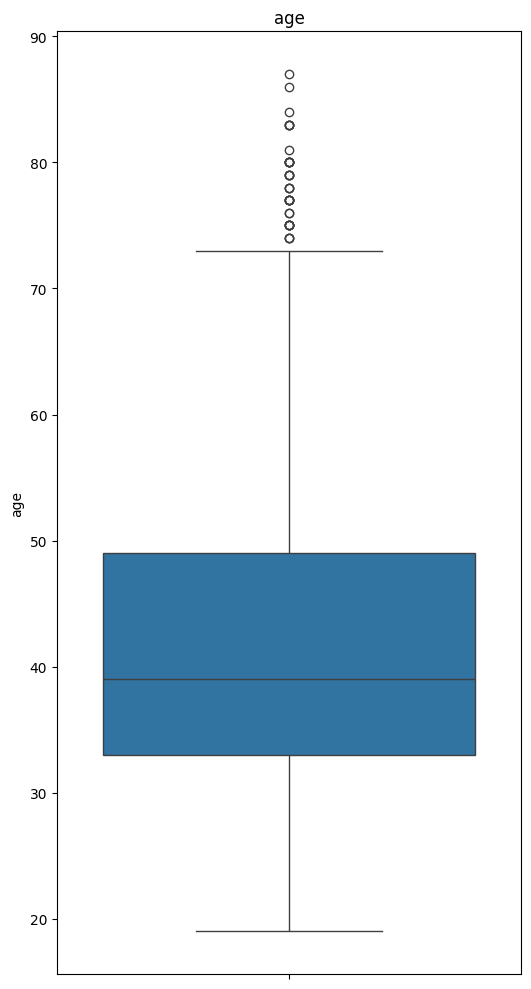

In [10]:
# create a figure with barplot subplots
plt.figure(figsize=(15, 10))
for i, feature in enumerate(numerical_columns, 1):
    plt.subplot(len(numerical_columns)//3 + 1, 3, i)
    sns.boxplot(y=df_bank[feature], showfliers=True)
    plt.title(feature)
plt.tight_layout()
plt.show()


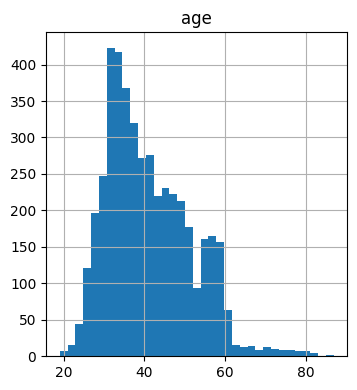

In [11]:
# create a figure with histogram subplots
plt.figure(figsize=(10, 4))
for i, feature in enumerate(numerical_columns, 1):
    plt.subplot(len(numerical_columns)//3 + 1, 3, i)
    df_bank[feature].hist(bins=35)
    plt.title(feature)
plt.tight_layout()
plt.show()


*[TODO] CONCLUSIE SCHRIJVEN OVER HISTOGRAMS*

## Feature engineering - iris

*[TODO] SCHRIJF INTRODUCTIE FEATURE ENGINEERING*

### Normalize numerical columns

*[TODO] NORMALIZATIE (ALS GEBRUIKT) KEUZE ONDERBOUWEN*

In [12]:
#-------------CODE HIER ALLEEN RELEVANT ALS WE MEER DAN AGE GEBRUIKEN-----------

# from sklearn.preprocessing import MinMaxScaler
# import sklearn.preprocessing

# # Initialize the MinMaxScaler
# scaler = MinMaxScaler()

# # Columns to normalize
# columns_to_normalize = [col for col in numerical_columns if col not in ['age', 'day']]

# # Apply the scaler to the selected columns and rename them
# normalized_columns = [f"{col}_norm" for col in columns_to_normalize]
# df_demo[normalized_columns] = sklearn.preprocessing.normalize(df_demo[columns_to_normalize])

# print(df_demo[normalized_columns].head())

In [13]:
# # Outliers for normalized columns
# fig, axes = plt.subplots(3, 3, figsize=(15, 10))

# # Plot each normalized column in a separate subplot
# for i, column in enumerate(normalized_columns, 1):
#     plt.subplot(len(normalized_columns)//3 + 1, 3, i)
#     sns.boxplot(y=df_bank[column], showfliers=True)
#     plt.title(column)
# plt.tight_layout()
# plt.show()


In [14]:
# plt.figure(figsize=(15, 10))
# for i, feature in enumerate(normalized_columns, 1):
#     plt.subplot(len(normalized_columns)//3 + 1, 3, i)
#     df_bank[feature].hist(bins=35)
#     plt.title(feature)
# plt.tight_layout()
# plt.show()


*[TODO] ALS RELEVANT: CONCLUSIE OVER NORMALIZERING SCHRIJVEN*

### One-hot coding of categorical features

*[TODO] INTRODUCEER EN ONDERBOUW ONE-HOT*

In [15]:
# Apply one-hot encoding to categorical columns
df_demo_encoded = pd.get_dummies(df_demo, columns=categorical_columns)

print(df_demo_encoded.columns)

#Encode the target variable
df_demo_encoded['y'] = df_demo_encoded['y'].map({'yes': 1, 'no': 0})

Index(['age', 'y', 'job_admin.', 'job_blue-collar', 'job_entrepreneur',
       'job_housemaid', 'job_management', 'job_retired', 'job_self-employed',
       'job_services', 'job_student', 'job_technician', 'job_unemployed',
       'marital_divorced', 'marital_married', 'marital_single',
       'education_primary', 'education_secondary', 'education_tertiary'],
      dtype='object')


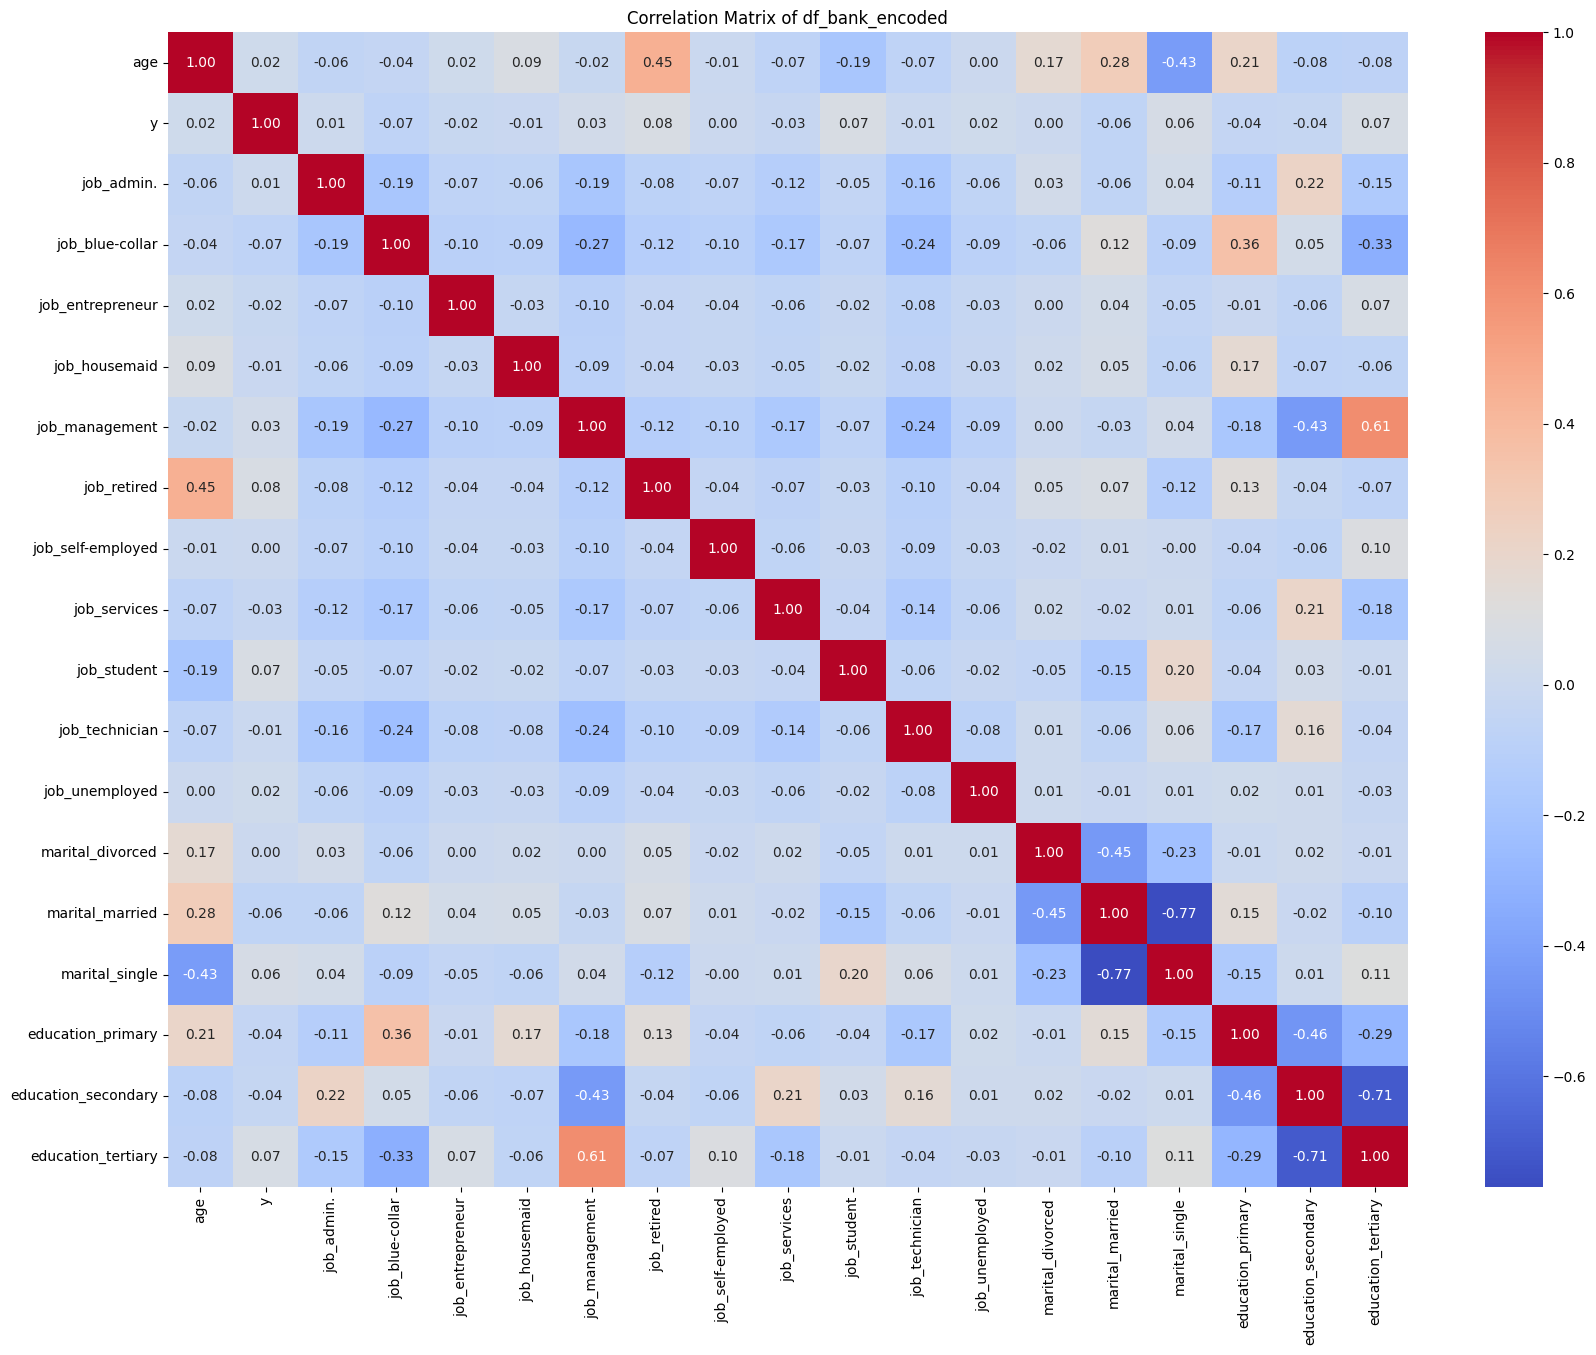

In [16]:
# Calculate the correlation matrix
correlation_matrix = df_demo_encoded.corr()

# Plot the heatmap
plt.figure(figsize=(20, 15))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm')
plt.title('Correlation Matrix of df_bank_encoded')
plt.show()

*[TODO] Uitleg en conclusie schrijven over correlation matrix*

In [17]:
# Calculate the correlation matrix for the target variable 'y' and other features
y_corr = df_demo_encoded.corr()[['y']]

print(y_corr)

                            y
age                  0.024760
y                    1.000000
job_admin.           0.007173
job_blue-collar     -0.070973
job_entrepreneur    -0.019513
job_housemaid       -0.014936
job_management       0.032032
job_retired          0.078686
job_self-employed    0.001161
job_services        -0.028754
job_student          0.073955
job_technician      -0.007300
job_unemployed       0.021305
marital_divorced     0.003044
marital_married     -0.060928
marital_single       0.064084
education_primary   -0.040155
education_secondary -0.035901
education_tertiary   0.070523


*[TODO] ONDERBOUW KEUZE OM TE FILTEREN OP HOGE CORRELATIE (ALS RELEVANT)*

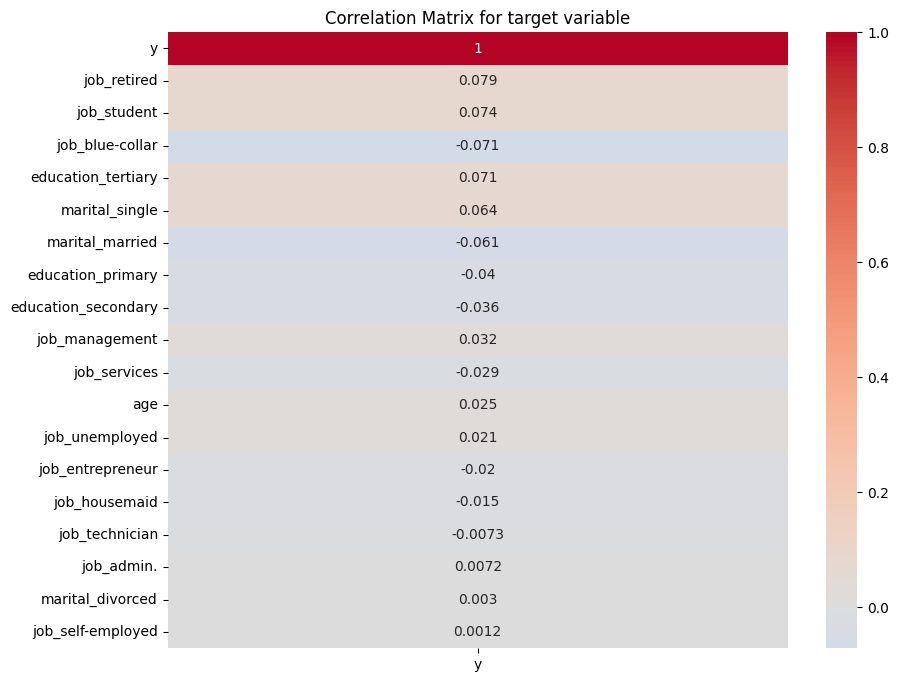

In [18]:
# Filter the correlation matrix for y_no and y_yes where the absolute value of correlation is higher than 0.1
#filtered_corr_matrix = y_corr[(y_corr['y_yes'].abs() > 0.1)]
filtered_corr_matrix = y_corr

#Sort the values by the absolute value of correlation for visualization purposes
filtered_corr_matrix = filtered_corr_matrix.reindex(filtered_corr_matrix['y'].abs().sort_values(ascending=False).index)

# Plot the heatmap for the filtered correlation matrix
plt.figure(figsize=(10, 8))
sns.heatmap(filtered_corr_matrix, annot=True, cmap='coolwarm', center=0)
plt.title('Correlation Matrix for target variable')
plt.show()

*[TODO] CONCLUSIE SCHRIJVEN OVER CORRELATION MATRIX*

In [19]:
#---------------VERANDER LATER ALS RELEVANT ADHV CORRELATION MATRIX-----------
key_features = df_demo_encoded.columns 

In [20]:
# Create pair plots
# sns.pairplot(df_demo_encoded[key_features])
# plt.show()

Ik denk dat deze pair plot overbodig is, geeft ons vgm niet veel extra informatie
- Onno

### Sampling considerations
There are way more y_no than y_yes. We have decided NOT to resample this, and instead use the imbalanced dataset. We will evaluate the models based on the AUC, which is a better metric for imbalanced datasets. This will also be explained later in the notebook.

In [21]:
# Separate majority and minority classes
df_majority = df_demo_encoded[df_demo_encoded['y'] == 0]
df_minority = df_demo_encoded[df_demo_encoded['y'] == 1]
print("Succesfull calls (Subscriptions to term deposit, y=1):", df_minority.shape[0])
print("Unsuccesfull calls (no subscription, y=0):", df_majority.shape[0])

Succesfull calls (Subscriptions to term deposit, y=1): 5021
Unsuccesfull calls (no subscription, y=0): 38172


## Clustering

In this section, we will be applying two clustering algorithms to the data: DBSCAN and Fuzzy C-Means Clustering. We chose to use DBSCAN because we saw from the EDA that we have a lot of outliers in our attributes. The decision for Fuzzy C-Means Clustering was made as we expect high overlap between the clusters, which this clustering method works well for.

### Cluster algorithm 1 - DBSCAN

In [22]:
df_final = df_demo_encoded
df_final

,age,y,job_admin.,job_blue-collar,job_entrepreneur,job_housemaid,job_management,job_retired,job_self-employed,job_services,job_student,job_technician,job_unemployed,marital_divorced,marital_married,marital_single,education_primary,education_secondary,education_tertiary
0,58,0,False,False,False,False,True,False,False,False,False,False,False,False,True,False,False,False,True
1,44,0,False,False,False,False,False,False,False,False,False,True,False,False,False,True,False,True,False
2,33,0,False,False,True,False,False,False,False,False,False,False,False,False,True,False,False,True,False
5,35,0,False,False,False,False,True,False,False,False,False,False,False,False,True,False,False,False,True
6,28,0,False,False,False,False,True,False,False,False,False,False,False,False,False,True,False,False,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45206,51,1,False,False,False,False,False,False,False,False,False,True,False,False,True,False,False,False,True
45207,71,1,False,False,False,False,False,True,False,False,False,False,False,True,False,False,True,False,False
45208,72,1,False,False,False,False,False,True,False,False,False,False,False,False,True,False,False,True,False
45209,57,0,False,True,False,False,False,False,False,False,False,False,False,False,True,False,False,True,False


In [23]:
from sklearn.neighbors import NearestNeighbors
from matplotlib import pyplot as plt
 
neighbors = NearestNeighbors(n_neighbors=20)
neighbors_fit = neighbors.fit(df_final)
distances, indices = neighbors_fit.kneighbors(df_final)
distances = np.sort(distances, axis=0)[:,1]


KeyboardInterrupt: 

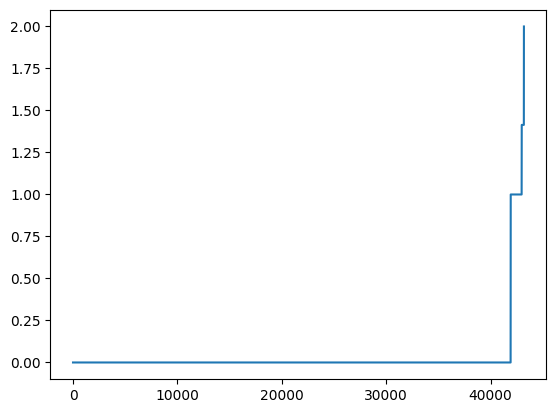

In [ ]:
# plt.xlim(7980, 8000)
# plt.axhline(y=140, color='r', linestyle='--')
plt.plot(distances)


In [ ]:
from sklearn.cluster import DBSCAN
from sklearn.metrics import silhouette_score

#-------------AURELIA NOG AANPASSEN OM NIET HARDCODED TE ZIJN -----------------
# Define a range of eps and min_samples values to test
eps_values = np.arange(140, 150.0, 1)  # Adjust the range and step as necessary
min_samples_values = range(20, 40)

# Dictionary to store the results
best_score = -1
best_params = {}

for eps in eps_values:
    for min_samples in min_samples_values:
        # Apply DBSCAN
        dbscan = DBSCAN(eps=eps, min_samples=min_samples)
        labels = dbscan.fit_predict(df_upsampled[key_features])
        
        # Only compute silhouette score if there is more than 1 cluster
        if len(set(labels)) > 1:
            score = silhouette_score(df_upsampled[key_features], labels)
            print(f"eps: {eps}, min_samples: {min_samples}, silhouette score: {score}")
            
            # Check if this is the best score
            if score > best_score:
                best_score = score
                best_params = {'eps': eps, 'min_samples': min_samples}

print(f"Best params: {best_params}, Best silhouette score: {best_score}")


NameError: name 'df_upsampled' is not defined

In [ ]:
df_final

,duration,pdays,previous,poutcome_success,month_oct,contact_cellular,y_yes_standardized
0,79,-1,0,0,1,1,-0.360902
1,220,339,4,0,0,1,-0.360902
2,185,330,1,0,0,1,-0.360902
3,199,-1,0,0,0,0,-0.360902
4,226,-1,0,0,0,0,-0.360902
...,...,...,...,...,...,...,...
382,234,-1,0,0,0,0,2.770838
1574,138,-1,0,0,0,1,2.770838
3250,269,541,3,1,1,1,2.770838
84,224,-1,0,0,0,1,2.770838


In [ ]:
# Run DBSCAN clustering
dbscan = DBSCAN(eps=144.0, min_samples=31)  # Values based on previous cell
df_final['cluster'] = dbscan.fit_predict(df_final[key_features])

C:\Users\20202631\AppData\Local\Temp\ipykernel_21728\241219739.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_final['cluster'] = dbscan.fit_predict(df_final[key_features])


In [ ]:
sum(df_final['cluster'].unique())

-1

c:\Users\20202631\AppData\Local\anaconda3v2\Lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


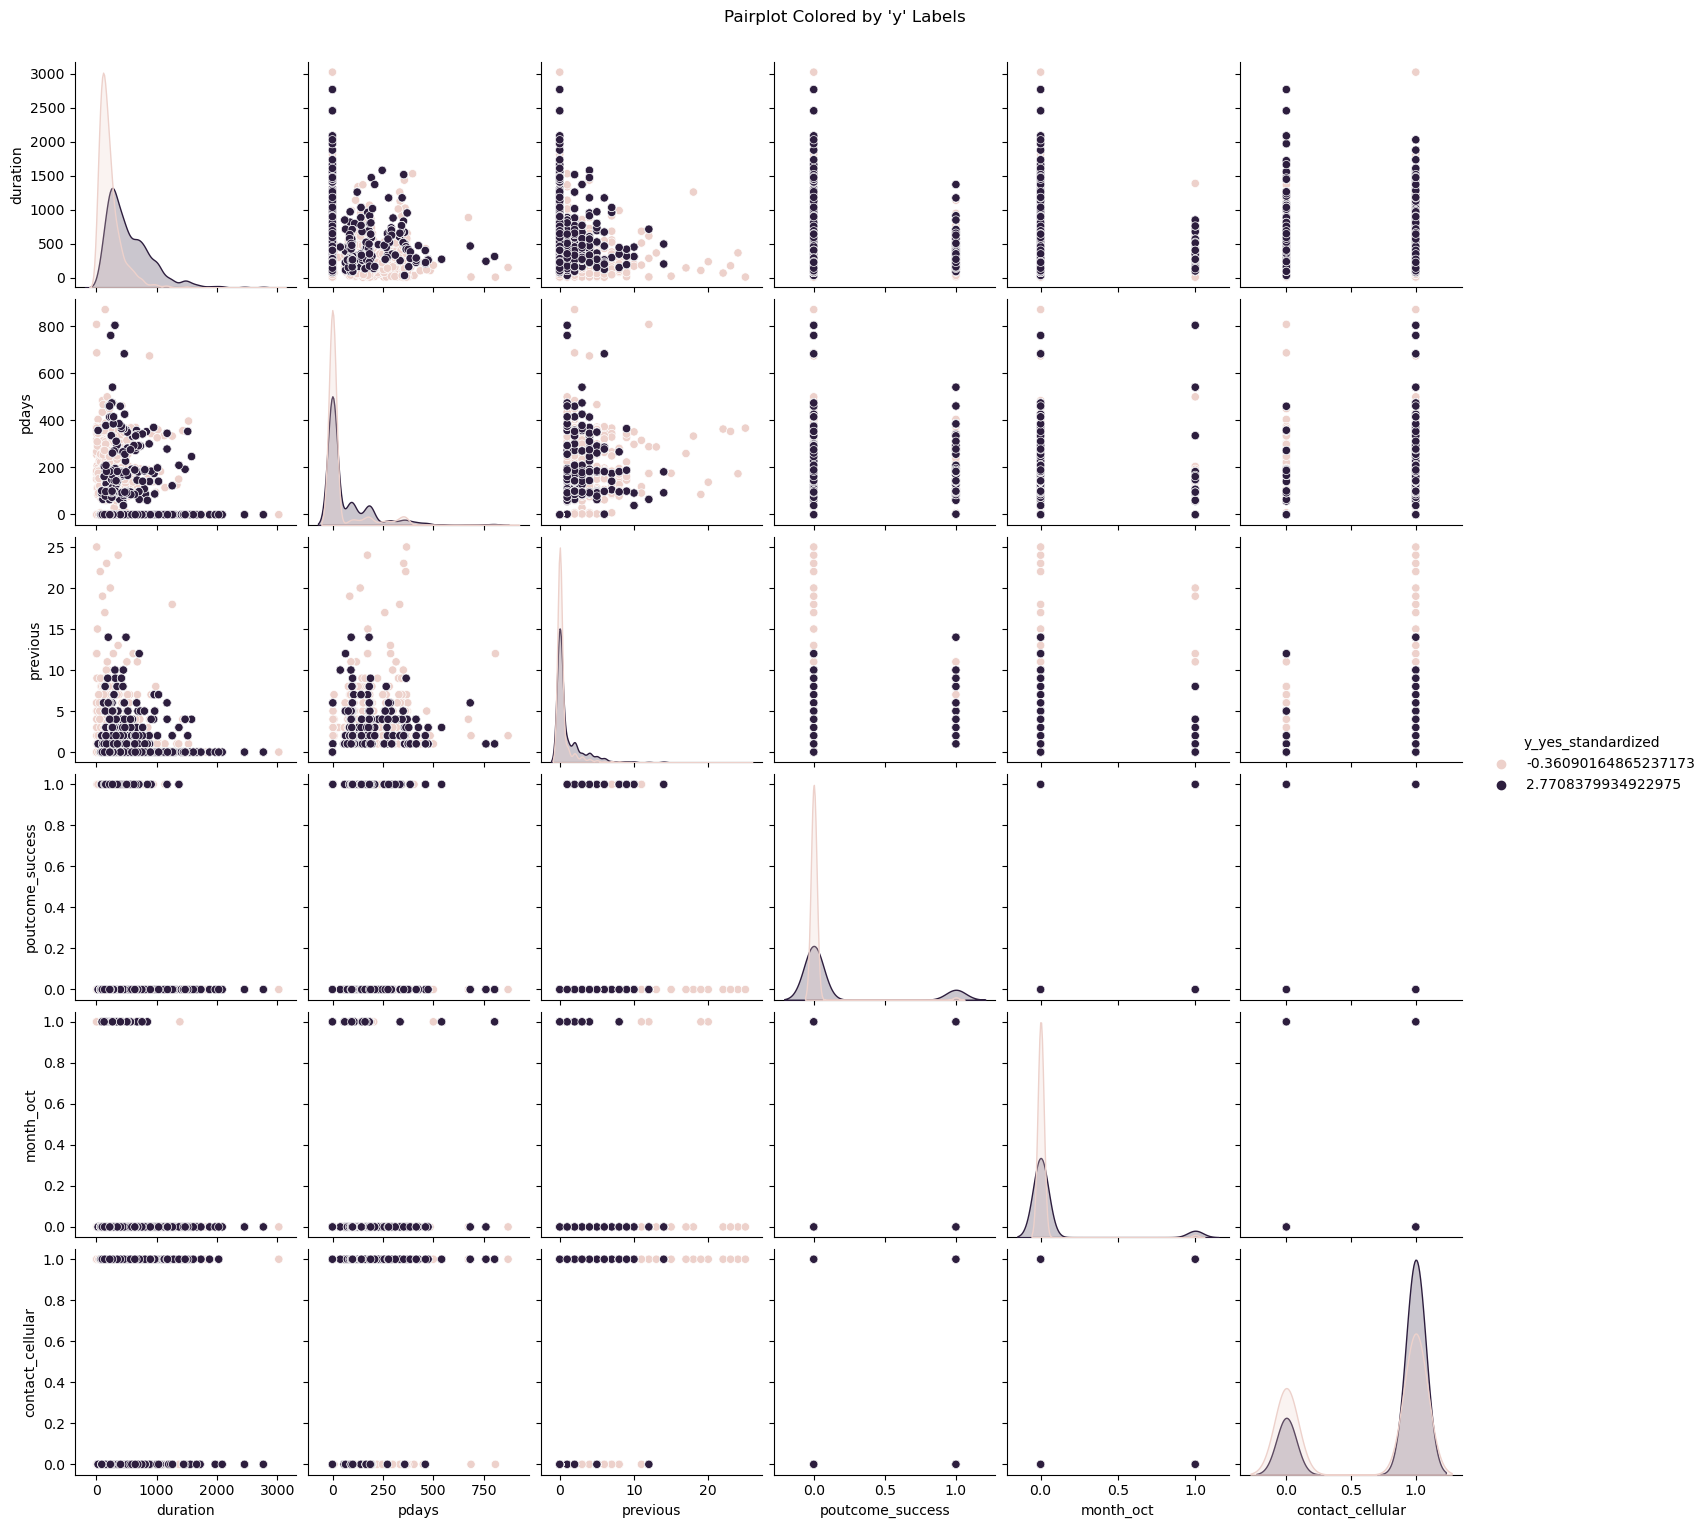

In [ ]:
# Plot the pairplot with hue based on the 'y' labels
sns.pairplot(df_final, vars=key_features, 
             hue='y_yes_standardized')  # 1 is yes, 0 is no
plt.suptitle("Pairplot Colored by 'y' Labels", y=1.02)
plt.show()


c:\Users\20202631\AppData\Local\anaconda3v2\Lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


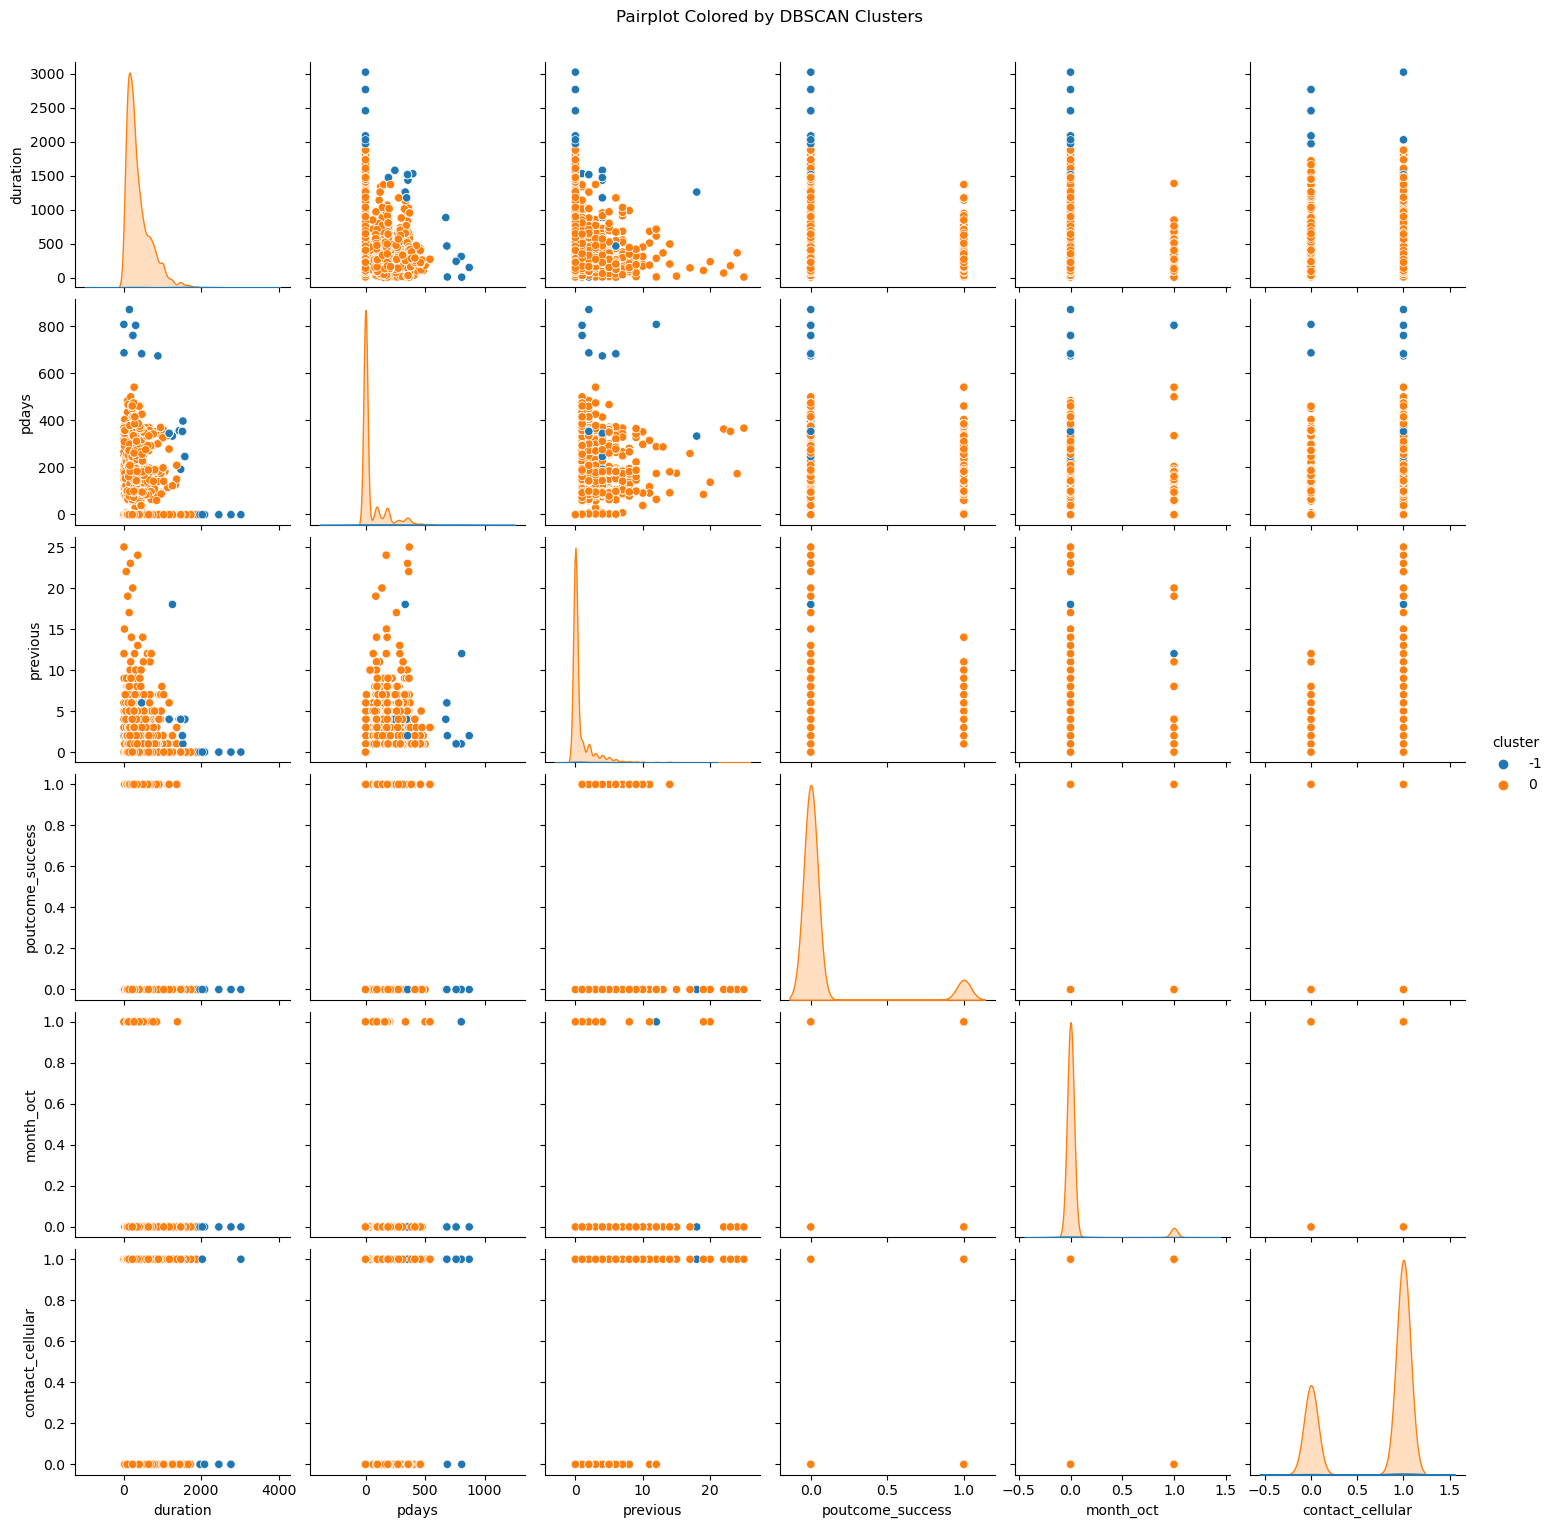

In [ ]:
# Plot the pairplot with hue based on the DBSCAN clusters
sns.pairplot(df_final, vars=key_features, 
             hue='cluster', palette='tab10')
plt.suptitle("Pairplot Colored by DBSCAN Clusters", y=1.02)
plt.show()

### Cluster algorithm 2  - Fuzzy C-Means Clustering

In [ ]:
# Redefining the cluster_range and accuracies for plotting process
cluster_range = range(1,11)
accuracies = []
all_clusters = []
data = df_upsampled[key_features]

# Perform Fuzzy C-Means clustering for each number of clusters
for n_clusters in cluster_range:
    # Perform fuzzy C-means clustering
    cntr, u, u0, d, jm, p, fpc = fuzz.cluster.cmeans(data.T, n_clusters, 2, error=0.005, maxiter=1000)
    
    # Assign clusters based on the highest membership
    clusters = np.argmax(u, axis=0)
    all_clusters.append(clusters)

print(all_clusters)

AttributeError: module 'fuzz' has no attribute 'cluster'

c:\Users\20201222\AppData\Local\anaconda3\Lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


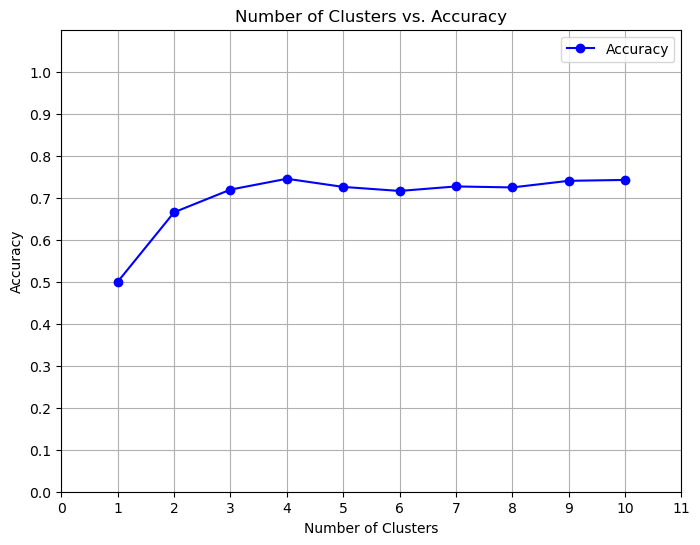

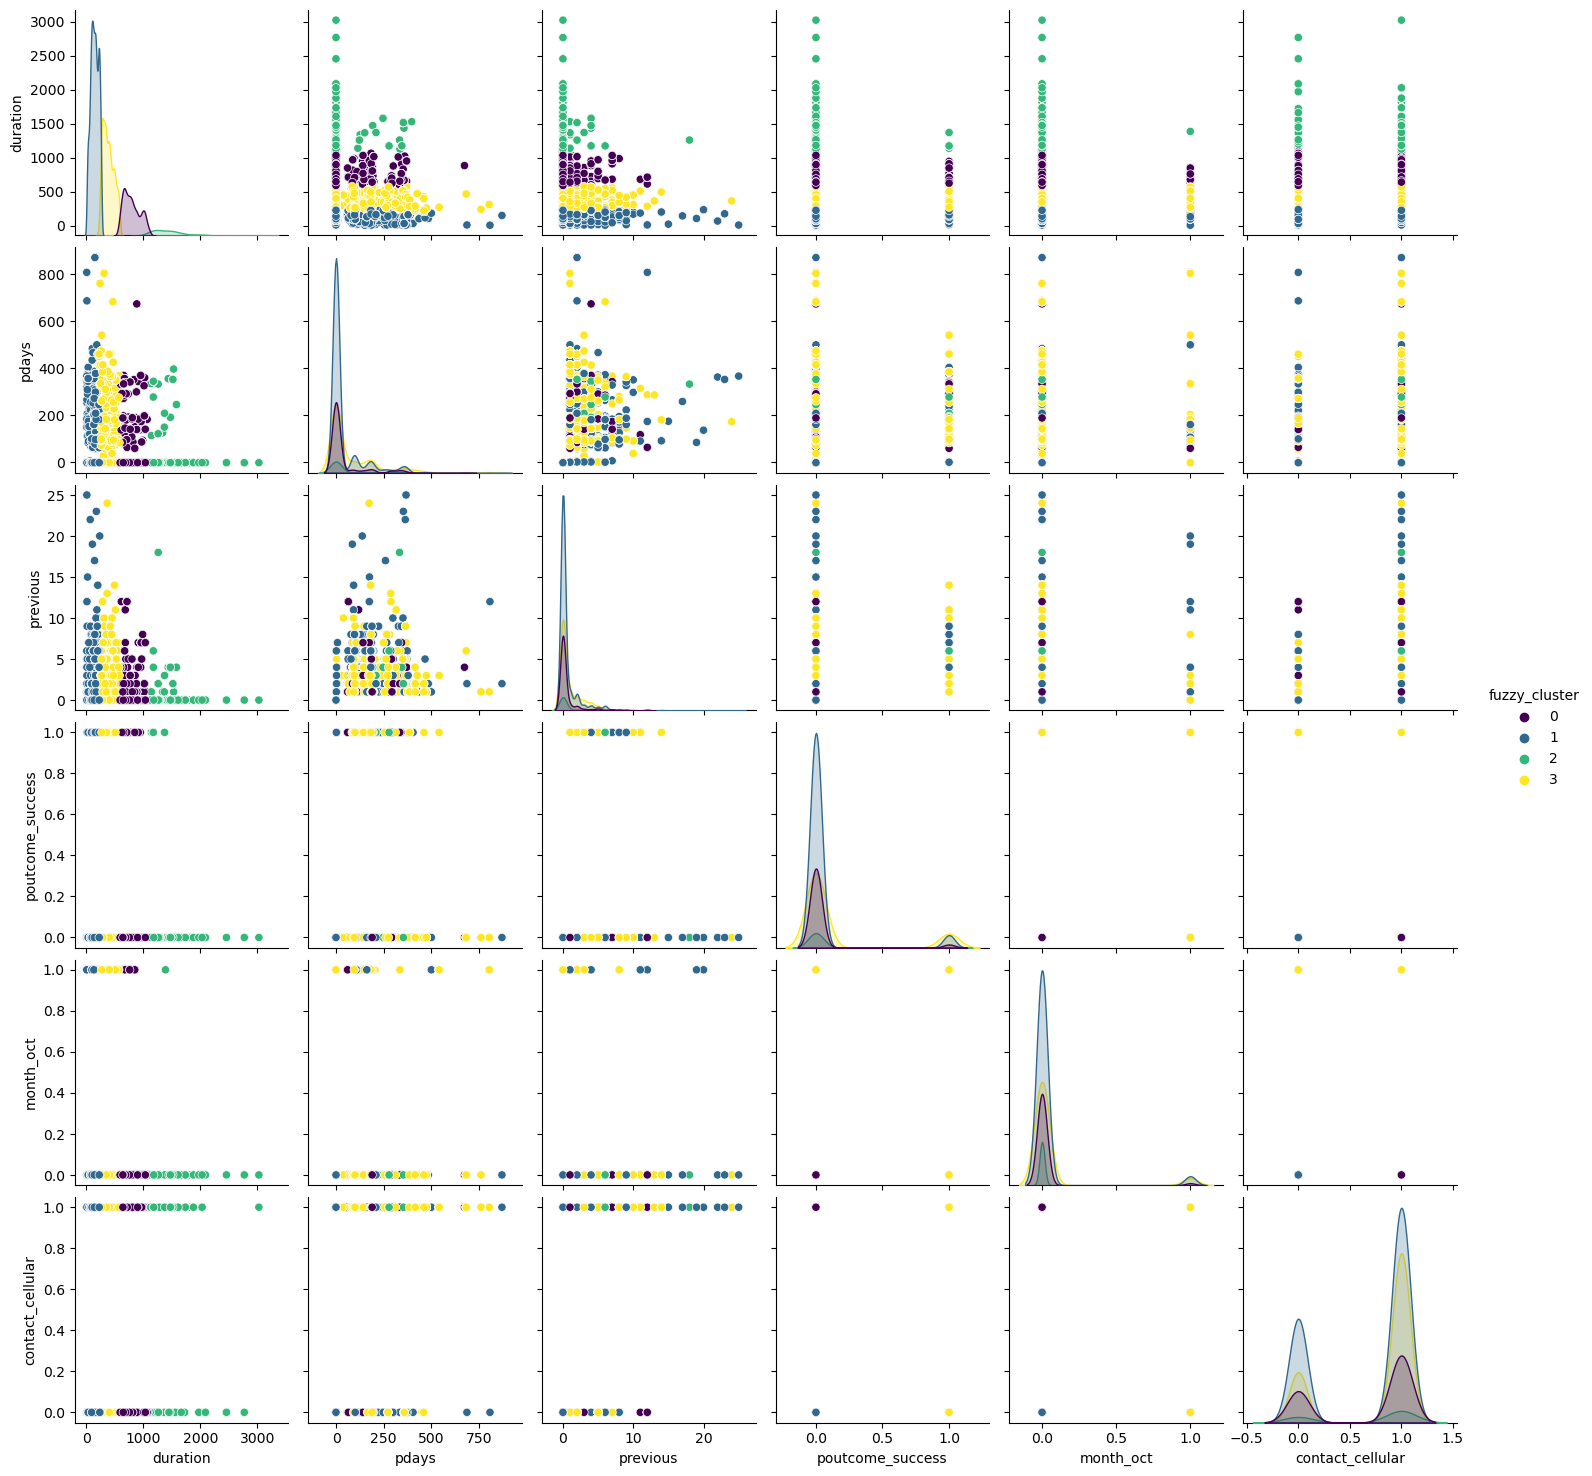

Clustering Accuracies: [0.5, 0.665375, 0.719375, 0.745125, 0.72575, 0.716125, 0.726875, 0.7245, 0.74025, 0.742375]


In [ ]:
from sklearn.metrics import confusion_matrix

true_labels = df_upsampled['y_yes']

# Calculate accuracies for each clustering result
for clusters in all_clusters:
    # Using sklearn's confusion_matrix to generate the contingency matrix
    contingency_matrix = confusion_matrix(true_labels, clusters)
    
    # For each cluster, find the maximum true label count
    correct_predictions = sum(np.max(contingency_matrix, axis=0))

    # Calculate accuracy
    accuracy = correct_predictions / len(true_labels)
    accuracies.append(accuracy)


# Perform fuzzy c-means clustering with 4 clusters
n_clusters_4 = 4
cntr, u, u0, d, jm, p, fpc = fuzz.cluster.cmeans(data.T, n_clusters_4, 2, error=0.005, maxiter=1000)
clusters4 = np.argmax(u, axis=0)

# Add the cluster assignment to the dataframe
df_upsampled['fuzzy_cluster'] = clusters4

# Plotting number of clusters vs. accuracy
plt.figure(figsize=(8, 6))
plt.plot(cluster_range, accuracies, marker='o', color='b', label="Accuracy")
plt.title("Number of Clusters vs. Accuracy")
plt.xlabel("Number of Clusters")
plt.ylabel("Accuracy")
plt.xlim(0, 11)  # Setting x-axis limit
plt.ylim(0, 1.1)  # Setting y-axis limit
plt.xticks(range(0, 12))  # Setting x-ticks every 1 increment
plt.yticks(np.arange(0, 1.1, 0.1))  # Setting y-ticks every 0.1 increment
plt.grid()
plt.legend()

# Plot the clusters using pairplot
sns.pairplot(df_upsampled, vars=key_features, hue='fuzzy_cluster', palette='viridis')
plt.show()

# Print final clustering accuracy
print("Clustering Accuracies:", accuracies)

In [ ]:
df_upsampled[key_features + ['y_yes', 'fuzzy_cluster']]

,duration,pdays,previous,poutcome_success,month_oct,contact_cellular,y_yes,fuzzy_cluster
0,79,-1,0,0,1,1,0,1
1,220,339,4,0,0,1,0,1
2,185,330,1,0,0,1,0,1
3,199,-1,0,0,0,0,0,1
4,226,-1,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...
382,234,-1,0,0,0,0,1,1
1574,138,-1,0,0,0,1,1,1
3250,269,541,3,1,1,1,1,3
84,224,-1,0,0,0,1,1,1


In [ ]:
# return cluster centers cntr 
print(f"Clusters centers: {cntr}")
# return membership matrix u
print(f"Memership matrix: {u}")

Clusters centers: [[7.81380574e+02 2.67251927e+01 4.85496060e-01 3.56380565e-02
  2.94448441e-02 6.66472369e-01]
 [1.37724706e+02 2.55125620e+01 4.68051948e-01 4.92094677e-02
  3.88639043e-02 6.62201936e-01]
 [1.45590493e+03 3.79074559e+01 5.39510341e-01 2.18752263e-02
  5.39835230e-03 6.79820556e-01]
 [3.76654292e+02 5.39167503e+01 9.27666088e-01 1.34969472e-01
  5.66393600e-02 7.54560416e-01]]
Memership matrix: [[0.00795946 0.11009724 0.10059365 ... 0.1887697  0.01950565 0.56483723]
 [0.94704025 0.43247816 0.47426322 ... 0.35157773 0.74568793 0.09469111]
 [0.00207277 0.02807841 0.02648036 ... 0.05986421 0.00399899 0.03814265]
 [0.04292752 0.42934619 0.39866278 ... 0.39978836 0.23080743 0.302329  ]]


## Association rules

In [ ]:
df_ass_rules = df_upsampled[key_features + ['y_yes']]
df_ass_rules = df_ass_rules.drop(['duration', 'pdays'], axis=1)
df_ass_rules

,previous,poutcome_success,month_oct,contact_cellular,y_yes
0,0,0,1,1,0
1,4,0,0,1,0
2,1,0,0,1,0
3,0,0,0,0,0
4,0,0,0,0,0
...,...,...,...,...,...
382,0,0,0,0,1
1574,0,0,0,1,1
3250,3,1,1,1,1
84,0,0,0,1,1


Implementation of Apriori

In [ ]:
df_ass_rules

,previous,poutcome_success,month_oct,contact_cellular,y_yes
0,0,0,1,1,0
1,4,0,0,1,0
2,1,0,0,1,0
3,0,0,0,0,0
4,0,0,0,0,0
...,...,...,...,...,...
382,0,0,0,0,1
1574,0,0,0,1,1
3250,3,1,1,1,1
84,0,0,0,1,1


In [ ]:
#I don't know why, but although this results in the exact same df it won't run without it
def encode(item_freq):
    res = 0
    if item_freq > 0:
        res = 1
    return res
    
basket_input = df_ass_rules.applymap(encode)

In [ ]:
from mlxtend.frequent_patterns import apriori, association_rules

# Write your code for Association rules with 10% support and 20% confidence
frequent_items = apriori(basket_input, min_support=0.1, use_colnames=True)
frequent_items

c:\Users\20202631\AppData\Local\anaconda3v2\Lib\site-packages\mlxtend\frequent_patterns\fpcommon.py:109: DeprecationWarning: DataFrames with non-bool types result in worse computationalperformance and their support might be discontinued in the future.Please use a DataFrame with bool type
  warnings.warn(


,support,itemsets
0,0.251625,(previous)
1,0.705500,(contact_cellular)
2,0.500000,(y_yes)
3,0.225750,"(previous, contact_cellular)"
4,0.172625,"(previous, y_yes)"
5,0.395500,"(contact_cellular, y_yes)"
6,0.154875,"(previous, contact_cellular, y_yes)"


In [ ]:
# with 20% Confidence
rules = association_rules(frequent_items, metric='confidence', min_threshold=0.20)
rules

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction,zhangs_metric
0,(previous),(contact_cellular),0.251625,0.705500,0.225750,0.897168,1.271677,0.048229,2.863906,0.285468
1,(contact_cellular),(previous),0.705500,0.251625,0.225750,0.319986,1.271677,0.048229,1.100529,0.725423
2,(previous),(y_yes),0.251625,0.500000,0.172625,0.686041,1.372081,0.046813,1.592563,0.362359
3,(y_yes),(previous),0.500000,0.251625,0.172625,0.345250,1.372081,0.046813,1.142994,0.542361
4,(contact_cellular),(y_yes),0.705500,0.500000,0.395500,0.560595,1.121191,0.042750,1.137903,0.367032
5,(y_yes),(contact_cellular),0.500000,0.705500,0.395500,0.791000,1.121191,0.042750,1.409091,0.216182
6,"(previous, contact_cellular)",(y_yes),0.225750,0.500000,0.154875,0.686047,1.372093,0.042000,1.592593,0.350257
7,"(previous, y_yes)",(contact_cellular),0.172625,0.705500,0.154875,0.897176,1.271688,0.033088,2.864116,0.258219
8,"(contact_cellular, y_yes)",(previous),0.395500,0.251625,0.154875,0.391593,1.556256,0.055357,1.230056,0.591286
9,(previous),"(contact_cellular, y_yes)",0.251625,0.395500,0.154875,0.615499,1.556256,0.055357,1.572169,0.477611


In [ ]:
# Order the most frequent item combinations in the entire dataset, by sorting the dataset by support, confidence, and lift
rules_sorted = rules.sort_values(["support", "confidence","lift"],axis = 0, ascending = False)
rules_sorted

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction,zhangs_metric
5,(y_yes),(contact_cellular),0.500000,0.705500,0.395500,0.791000,1.121191,0.042750,1.409091,0.216182
4,(contact_cellular),(y_yes),0.705500,0.500000,0.395500,0.560595,1.121191,0.042750,1.137903,0.367032
0,(previous),(contact_cellular),0.251625,0.705500,0.225750,0.897168,1.271677,0.048229,2.863906,0.285468
1,(contact_cellular),(previous),0.705500,0.251625,0.225750,0.319986,1.271677,0.048229,1.100529,0.725423
2,(previous),(y_yes),0.251625,0.500000,0.172625,0.686041,1.372081,0.046813,1.592563,0.362359
3,(y_yes),(previous),0.500000,0.251625,0.172625,0.345250,1.372081,0.046813,1.142994,0.542361
7,"(previous, y_yes)",(contact_cellular),0.172625,0.705500,0.154875,0.897176,1.271688,0.033088,2.864116,0.258219
6,"(previous, contact_cellular)",(y_yes),0.225750,0.500000,0.154875,0.686047,1.372093,0.042000,1.592593,0.350257
9,(previous),"(contact_cellular, y_yes)",0.251625,0.395500,0.154875,0.615499,1.556256,0.055357,1.572169,0.477611
8,"(contact_cellular, y_yes)",(previous),0.395500,0.251625,0.154875,0.391593,1.556256,0.055357,1.230056,0.591286


We find that all the rules have a positive lift, meaning that they're good influential rules. The rules are sorted based importance.

The antecedents explain the consequents, as we are interested in explaining the y_yes variable, which indicates whether someone has received a loan or not, we will only be looking at those.

In [ ]:
# Done manually because of frozenset
rules_sorted = rules_sorted.drop([5, 0, 1, 3, 7, 8, 11])
rules_sorted

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction,zhangs_metric
4,(contact_cellular),(y_yes),0.705500,0.500000,0.395500,0.560595,1.121191,0.042750,1.137903,0.367032
2,(previous),(y_yes),0.251625,0.500000,0.172625,0.686041,1.372081,0.046813,1.592563,0.362359
6,"(previous, contact_cellular)",(y_yes),0.225750,0.500000,0.154875,0.686047,1.372093,0.042000,1.592593,0.350257
9,(previous),"(contact_cellular, y_yes)",0.251625,0.395500,0.154875,0.615499,1.556256,0.055357,1.572169,0.477611
10,(contact_cellular),"(previous, y_yes)",0.705500,0.172625,0.154875,0.219525,1.271688,0.033088,1.060092,0.725445


We find that that:"
1. given someone has cellular contact, there's a 39.55% chance they receive a loan.
2. Given someoen has previously received a loan, there's a 17.26% chance they receive a loan.
3. Given that they both have cellular contact, and received a loan previously, there's a 15.49% chance they receive a loan.
4. 5. TODO: debate whether these are necessary.

Visalising the confidence

In [ ]:
rules

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction,zhangs_metric
0,(previous),(contact_cellular),0.251625,0.705500,0.225750,0.897168,1.271677,0.048229,2.863906,0.285468
1,(contact_cellular),(previous),0.705500,0.251625,0.225750,0.319986,1.271677,0.048229,1.100529,0.725423
2,(previous),(y_yes),0.251625,0.500000,0.172625,0.686041,1.372081,0.046813,1.592563,0.362359
3,(y_yes),(previous),0.500000,0.251625,0.172625,0.345250,1.372081,0.046813,1.142994,0.542361
4,(contact_cellular),(y_yes),0.705500,0.500000,0.395500,0.560595,1.121191,0.042750,1.137903,0.367032
5,(y_yes),(contact_cellular),0.500000,0.705500,0.395500,0.791000,1.121191,0.042750,1.409091,0.216182
6,"(previous, contact_cellular)",(y_yes),0.225750,0.500000,0.154875,0.686047,1.372093,0.042000,1.592593,0.350257
7,"(previous, y_yes)",(contact_cellular),0.172625,0.705500,0.154875,0.897176,1.271688,0.033088,2.864116,0.258219
8,"(contact_cellular, y_yes)",(previous),0.395500,0.251625,0.154875,0.391593,1.556256,0.055357,1.230056,0.591286
9,(previous),"(contact_cellular, y_yes)",0.251625,0.395500,0.154875,0.615499,1.556256,0.055357,1.572169,0.477611


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


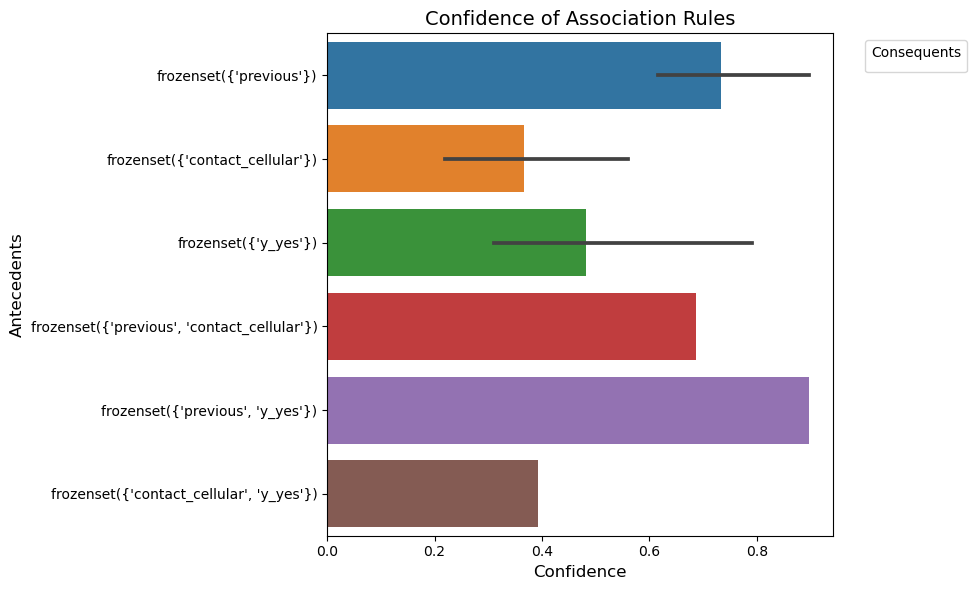

In [ ]:
# Create a bar plot for confidence values
plt.figure(figsize=(10, 6))
sns.barplot(x='confidence', y='antecedents',  data=rules)

# Add title and labels
plt.title('Confidence of Association Rules', fontsize=14)
plt.xlabel('Confidence', fontsize=12)
plt.ylabel('Antecedents', fontsize=12)
plt.legend(title='Consequents', bbox_to_anchor=(1.05, 1), loc='upper left')

# Show plot
plt.tight_layout()
plt.show()

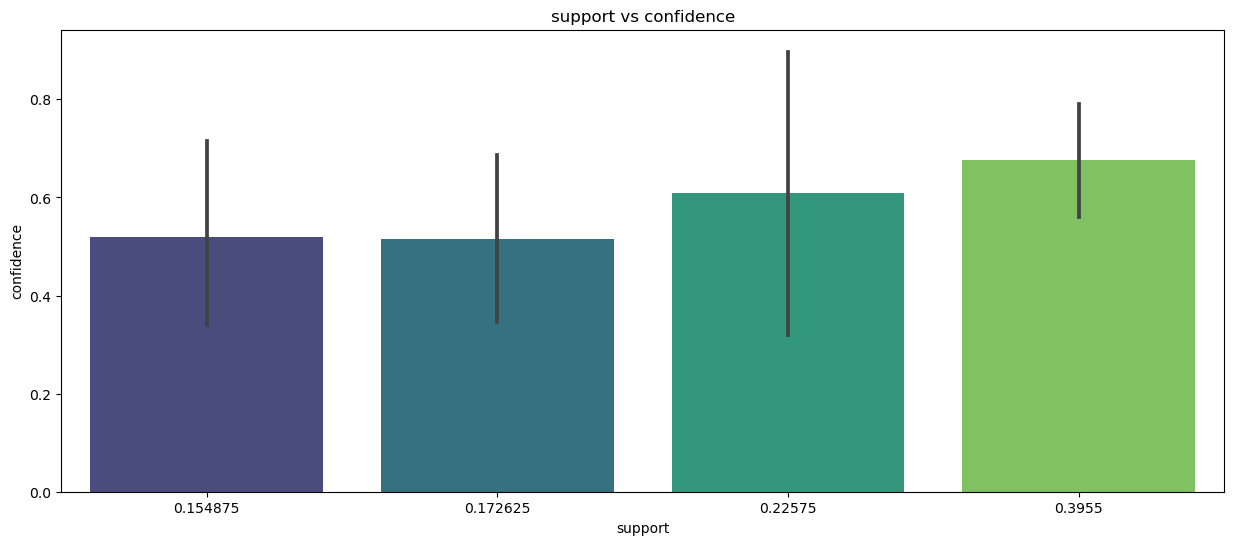

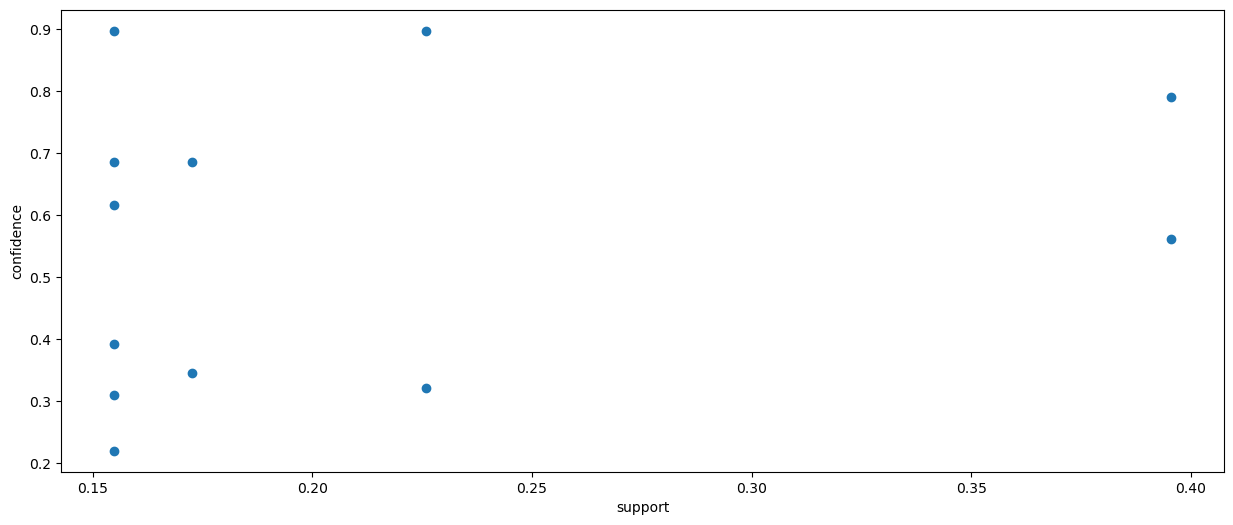

In [ ]:
#### Visualization of obtained rules
plt.figure(figsize=(15,6))
sns.barplot(x="support",y="confidence",data=rules, palette='viridis')
plt.title("support vs confidence")
plt.show()

plt.figure(figsize=(15,6))
plt.scatter(rules['support'],rules['confidence'])
plt.xlabel('support')
plt.ylabel('confidence') 
plt.show()

# Predictive Modelling


Now that we have performed EDA, feature engineering, clustering and association rule mining, we will move on to the predictive modelling part of the assignment. We will be using the following models:
- Support Vector Machine (SVM)
- eXtreme Gradient Boosting (XGBoost)
- Random Forest

These models were chosen because they are known to perform well on imbalanced datasets, which we have. We will be using the AUC as our evaluation metric, as it is a better metric for imbalanced datasets than accuracy. After evaluating all models the best performing will be chosen and finetuned for optimal performance.

First, we split the data into train and test data. We will use 80% of the data for training and 20% for testing. We will then train the models on the training data and evaluate them on the test data.

In [24]:
#Split data into train and test data
from sklearn.model_selection import train_test_split

X = df_demo_encoded[key_features]
y = df_demo_encoded['y']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=2)

SVM (Kyrie)

### XGBoost (Onno)

XGBoost (Extreme Gradient Boosting) is a powerful and efficient machine learning algorithm based on the gradient boosting framework. It builds a strong model by combining many weak learners, in our case decision trees, in an iterative way to minimize prediction errors. With each iteration, XGBoost focuses on improving the accuracy by adjusting for errors made in previous rounds, which leads to high performance and accuracy.

First, the optimal hyperparameters (optimizing for XXXXX) will be determined using Grid search Cross Validation. Then an XGBoost model will be trained on these parameters. Finally, in the evaluation section, the model will be evaluated on the test set and compared to the other two models in this notebook.

In [ ]:
#Import necessary libraries for XGBoost
from xgboost import XGBClassifier

#Import Gridsearch for hyperparameter tuning
from sklearn.model_selection import GridSearchCV

#Initialize the XGBClassifier
xgb = XGBClassifier()

#Initialize the parameter grid
param_grid = {
    'max_depth': [3, 4, 5],
    'learning_rate': [0.1, 0.01, 0.001],
    'n_estimators': [100, 200, 300],
    'gamma': [0, 0.1, 0.2],
}

#Perform grid search with 5-fold cross-validation (~30 seconds)
grid_search = GridSearchCV(estimator=xgb, param_grid=param_grid, cv=5, n_jobs=-1, scoring='roc_auc_ovr_weighted')
grid_search.fit(X_train, y_train)

#Print the best parameters
print(grid_search.best_params_)

ModuleNotFoundError: No module named 'xgboost'

After finding the best possible parameters for the XGBoost model, we will train it on the training set.

In [ ]:
#Initialize the XGBClassifier with the best parameters
xgb_best = XGBClassifier(**grid_search.best_params_)
xgb_best.fit(X_test, y_test)

NameError: name 'XGBClassifier' is not defined

NameError: name 'xgb_best' is not defined

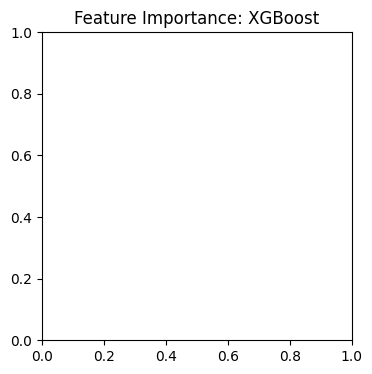

In [ ]:
#visualize feature importance
plt.figure(figsize=(4, 4));
plt.title('Feature Importance: XGBoost');
sns.barplot(x=xgb_best.feature_importances_, y=key_features);
plt.xlabel('Feature Importance');
plt.ylabel('Feature');
plt.show()

*[TODO] CONCLUSIE OVER FEATURE IMPORTANCES*

### Random Forest (Mila)

**Decision Trees**, the building blocks of **Random Forests**, make decisions based on conditional splits at each node. These splits are determined by comparing feature values to a threshold and partitioning the data accordingly to minimize a cost function, often related to the impurity of the nodes (e.g., Gini impurity or entropy in classification problems). **Random Forests enhance the robustness of Decision Trees by creating an ensemble**. Each tree in the forest is trained on a random subset of the data (bootstrapped samples), and at each split, a random subset of features is considered.

First, the optimal hyperparameters (optimizing for XXXXX) will be determined using Grid search Cross Validation. Then an Random Forest model will be trained on these parameters. Finally, in the evaluation section, the best random forest model will be evaluated on the test set and compared to the other two models in this notebook.

In [25]:
# Import necessary libraries for Random Forest
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold 

param_rf = {
    'n_estimators': np.linspace(10, 200, num=20, dtype=int),  # Number of trees in the forest
    'criterion': ['gini', 'entropy'],  # Function to measure the quality of a split
    'max_depth': [None, 10, 20, 30, 40, 50],  # Maximum depth of the tree
}

rf = RandomForestClassifier()
skf = StratifiedKFold(n_splits=5) #  Ensuring class balance at each fold
grid_search = GridSearchCV(rf, param_rf, scoring = 'roc_auc_ovr_weighted', cv=skf, return_train_score=True, n_jobs = -1).fit(X_train, y_train)

sorted(grid_search.cv_results_.keys())

cv_results = grid_search.cv_results_

results_df = pd.DataFrame({
    'mean_fit_time': cv_results['mean_fit_time'],
    'mean_score_time': cv_results['mean_score_time'],
    'mean_test_score': cv_results['mean_test_score'],
    'mean_train_score': cv_results['mean_train_score'],
    'param_criterion': cv_results['param_criterion'],
    'param_n_estimators': cv_results['param_n_estimators'],
    'std_test_score': cv_results['std_test_score'],
    'std_train_score': cv_results['std_train_score'],
    'rank_test_score': cv_results['rank_test_score']
})

# Apply the highlighting
results_df = results_df.sort_values(by = 'rank_test_score')

results_df['param_n_estimators'] = pd.to_numeric(results_df['param_n_estimators'])

# Print the best parameters
print(grid_search.best_params_)

{'criterion': 'gini', 'max_depth': None, 'n_estimators': np.int64(10)}


In [26]:
from helper_functions import highlight_best_worst

results_df_highlight = results_df.style.apply(highlight_best_worst, subset=['mean_test_score'])
results_df_highlight

,mean_fit_time,mean_score_time,mean_test_score,mean_train_score,param_criterion,param_n_estimators,std_test_score,std_train_score,rank_test_score
0,0.396950,0.050490,1.000000,1.000000,gini,10,0.000000,0.000000,1
1,0.778936,0.054200,1.000000,1.000000,gini,20,0.000000,0.000000,1
2,1.080512,0.056050,1.000000,1.000000,gini,30,0.000000,0.000000,1
3,1.333935,0.065536,1.000000,1.000000,gini,40,0.000000,0.000000,1
4,2.095909,0.134934,1.000000,1.000000,gini,50,0.000000,0.000000,1
5,2.328333,0.110317,1.000000,1.000000,gini,60,0.000000,0.000000,1
6,3.005740,0.177779,1.000000,1.000000,gini,70,0.000000,0.000000,1
7,3.629653,0.123517,1.000000,1.000000,gini,80,0.000000,0.000000,1
8,4.251513,0.207309,1.000000,1.000000,gini,90,0.000000,0.000000,1
9,3.925413,0.170118,1.000000,1.000000,gini,100,0.000000,0.000000,1


From the dataframe we can conclude that the best parameters for the Random Forest Model are:
- citerion:
- num, we will fit the model on the test set.

In [31]:
# Initialize the Random Forest Classifier with the best parameters
rf_best = RandomForestClassifier(**grid_search.best_params_)
rf_best = rf_best.fit(X_test, y_test)
rf_best.score(X_test, y_test)

1.0

The best parameters for the Random Forest Model are:
- Criterion: Entropy
- Number of estimators (number of trees): 80

# Comparison between the 3 models

In order to compare the performance of the three models, we will use the following metrics: accuracy, precision, recall, F1 score, and ROC AUC score. We will also plot the ROC curve for each model. In the end, the best model will be chosen based on the ROC AUC score as this most accurately represents the performance of the model.

In [28]:
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, roc_auc_score

SVM performance metrics:

In [ ]:
# Predict the target variable
y_pred_svm = svm_best.predict(df_final[key_features].drop('y', axis=1))

#Print evaluation measures
print('Accuracy:', np.mean(df_final['y'] == y_pred_svm))
print('Precision:', precision_score(df_final['y'], y_pred_svm))
print('Recall:', recall_score(df_final['y'], y_pred_svm))
print('F1 Score:', f1_score(df_final['y'], y_pred_svm))
print('ROC AUC Score:', roc_auc_score(df_final['y'], y_pred_svm))

#Visualize confusion matrix
plt.figure(figsize=(8, 6))
plt.title('Confusion Matrix: Random Forest')

sns.heatmap(confusion_matrix(df_final['y'], y_pred_svm), annot=True, fmt='d', cmap=plt.cm.Oranges)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

XGBoost performance metrics:

In [29]:
# Predict the target variable
y_pred_xgb = xgb_best.predict(df_final[key_features].drop('y', axis=1))

#Print evaluation measures
print('Accuracy:', np.mean(df_final['y'] == y_pred_xgb))
print('Precision:', precision_score(df_final['y'], y_pred_xgb))
print('Recall:', recall_score(df_final['y'], y_pred_xgb))
print('F1 Score:', f1_score(df_final['y'], y_pred_xgb))
print('ROC AUC Score:', roc_auc_score(df_final['y'], y_pred_xgb))

#Visualize confusion matrix
plt.figure(figsize=(8, 6))
plt.title('Confusion Matrix: Random Forest')

sns.heatmap(confusion_matrix(df_final['y'], y_pred_xgb), annot=True, fmt='d', cmap=plt.cm.Oranges)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

NameError: name 'xgb_best' is not defined

Random Forest performance metrics:

Accuracy: 1.0
Precision: 1.0
Recall: 1.0
F1 Score: 1.0
ROC AUC Score: 1.0


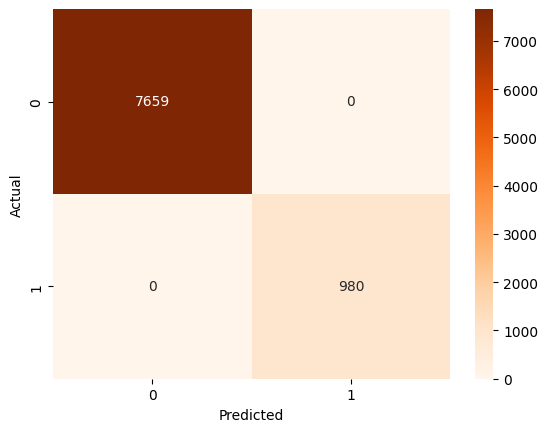

In [37]:
# Predict the target variable
y_pred_rf = rf_best.predict(X_test)

# Print evaluation measures
print('Accuracy:', np.mean(y_test == y_pred_rf))
print('Precision:', precision_score(y_test, y_pred_rf))
print('Recall:', recall_score(y_test, y_pred_rf))
print('F1 Score:', f1_score(y_test, y_pred_rf))
print('ROC AUC Score:', roc_auc_score(y_test, y_pred_rf))

# Visualize confusion matrix
sns.heatmap(confusion_matrix(y_test, y_pred_rf), annot=True, fmt='d', cmap=plt.cm.Oranges)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()


In conclusion, when comparing performances of the three models, blablblalbalabla